# Longitudinal atrophy generation model training

## Load libraries and utilities

In [8]:
import os
import numpy as np
import nibabel as nib
import SimpleITK as itk
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import functions.functions as fc
import functions.nifti_functions as nfc
import matplotlib.pyplot as plt  
import project_images_loader as pil

from utils.roi_measures import mad, ssim
from utils.extraction import extract_patches
from utils.reconstruction import perform_voting
from utils.match_intensities import match_intensities
from wnet import generate_wnet_model


## Define cascaded U-Net parameters

In [9]:
wparams = {}
wparams['input_channels'] = 2
wparams['output_channels'] = 1
wparams['latent_channels'] = 16
wparams['scale'] = [0.5, 0.5]
wparams['use_combined_loss'] = True
wparams['patch_shape'] = (32, 32, 32)
wparams['loss_weights'] = [1, 1, 1, 1.5, 3]

model = generate_wnet_model(wparams)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1, 32, 32,   0           []                               
                                32)]                                                              
                                                                                                  
 input_14 (InputLayer)          [(None, 1, 32, 32,   0           []                               
                                32)]                                                              
                                                                                                  
 input_15 (InputLayer)          [(None, 1, 32, 32,   0           []                               
                                32)]                                                        

## Loading training data
In this particular example, we use data from OASIS2 which has been registered to MNI and skull stripped previously. The folders used in this example are:
- db_location: file name pattern of input volumes
- db_seg_location: file name pattern of segmentation masks
- db_prob_location: file name pattern of segmentation probability maps

In [10]:
def load_train_patches():
    # step for the patches extraction 50% overlapping
    step = (16, 16, 16)  
    # util patches threshold 30%
    threshold = np.int32(0.30 * np.prod(wparams['patch_shape'][:]))

    # Initialization of empty arrays to store different types of patches
    in_baseline = np.empty((0, 1, ) + wparams['patch_shape'])
    in_gm_prob_labels = np.empty((0, 1, ) + wparams['patch_shape'])
    in_wm_prob_labels = np.empty((0, 1, ) + wparams['patch_shape'])
    in_csf_prob_labels = np.empty((0, 1, ) + wparams['patch_shape'])
    out_fup = np.empty((0, 1, ) + wparams['patch_shape'])

    # Iterate through patient indexes
    for patient_id in pil.IMG_NUMBERS_TRAIN[:5]:
        print(f"Patient {patient_id}")

        # load baseline and brain mask
        img_baseline, _ = pil.load_nsk_volume(patient_id, 1, pil.FOLDER_REGISTERED)
        img_baseline = img_baseline.reshape((1, ) + img_baseline.shape)

        mask_volume, _ = pil.load_brain_mask(patient_id, 1, pil.FOLDER_REGISTERED)
        mask_volume = mask_volume.reshape((1, ) + mask_volume.shape)

        # select usefull patches 
        mask_patches = extract_patches(mask_volume, (1, ) + wparams['patch_shape'], (1, ) + step)
        useful_patches = np.sum(mask_patches, axis=(1, 2, 3, 4)) > threshold
        del mask_patches

        # load follow up img
        img_fup, _ = pil.load_nsk_volume(patient_id, 2, pil.FOLDER_REGISTERED)
        img_fup = img_fup.reshape((1, ) + img_fup.shape)

        # load follow up prob labels
        img_gm_prob_label, img_wm_prob_label, img_csf_prob_label = pil.load_spm_labels(patient_id, 2, pil.FOLDER_REGISTERED, -1)
        img_gm_prob_label = img_gm_prob_label.reshape((1, ) + img_gm_prob_label.shape)
        img_wm_prob_label = img_wm_prob_label.reshape((1, ) + img_wm_prob_label.shape)
        img_csf_prob_label = img_csf_prob_label.reshape((1, ) + img_csf_prob_label.shape)

        # Extract patches
        baseline_patches = extract_patches(img_baseline, (1, ) + wparams['patch_shape'], (1, ) + step)
        baseline_patches = baseline_patches[useful_patches].reshape((-1, 1, ) + wparams['patch_shape'])

        fup_patches = extract_patches(img_fup, (1, ) + wparams['patch_shape'], (1, ) + step)
        fup_patches = fup_patches[useful_patches].reshape((-1, 1, ) + wparams['patch_shape'])

        gm_prob_patches = extract_patches(img_gm_prob_label, (1, ) + wparams['patch_shape'], (1, ) + step)
        gm_prob_patches = gm_prob_patches[useful_patches].reshape((-1, 1, ) + wparams['patch_shape'])

        wm_prob_patches = extract_patches(img_wm_prob_label, (1, ) + wparams['patch_shape'], (1, ) + step)
        wm_prob_patches = wm_prob_patches[useful_patches].reshape((-1, 1, ) + wparams['patch_shape'])

        csf_prob_patches = extract_patches(img_csf_prob_label, (1, ) + wparams['patch_shape'], (1, ) + step)
        csf_prob_patches = csf_prob_patches[useful_patches].reshape((-1, 1, ) + wparams['patch_shape'])

        # Store patches
        in_baseline = np.vstack((baseline_patches, in_baseline)).astype('float32')
        out_fup = np.vstack((fup_patches, out_fup)).astype('float32')
        in_gm_prob_labels = np.vstack((gm_prob_patches, in_gm_prob_labels)).astype('float32')
        in_wm_prob_labels = np.vstack((wm_prob_patches, in_wm_prob_labels)).astype('float32')
        in_csf_prob_labels = np.vstack((csf_prob_patches, in_csf_prob_labels)).astype('float32')

        del baseline_patches, gm_prob_patches, wm_prob_patches, csf_prob_patches, fup_patches

    return  in_baseline, out_fup, in_gm_prob_labels, in_wm_prob_labels, in_csf_prob_labels

# in_baseline, out_fup, in_gm_prob_labels, in_wm_prob_labels, in_csf_prob_labels = load_train_patches()


Show patches

In [11]:
# print(f'number of patches: {in_baseline.shape}')
# fc.show_patches(in_baseline)

## Training step

In [12]:
def train():
    patience = 10

    stopper = EarlyStopping(patience=patience)
    checkpointer = ModelCheckpoint(pil.get_model_path_name('model.h5'), save_best_only=True, save_weights_only=True)

    N = len(in_baseline)
    model.fit(
        [in_baseline, in_gm_prob_labels, in_wm_prob_labels, in_csf_prob_labels],
        [np.multiply(out_fup, in_gm_prob_labels >= 0.8),
        np.multiply(out_fup, in_wm_prob_labels >= 0.8),
        np.multiply(out_fup, in_csf_prob_labels >= 0.8),
        out_fup,
        out_fup],
        validation_split=0.3, epochs=5, batch_size=1,
        callbacks=[checkpointer, stopper])
# train()


In [13]:
# Save model weights
# model.save_weights(pil.get_model_path_name('final_model.h5'))


## Load model leading to the lowest validation loss

In [14]:
# Load model weights
model.load_weights(pil.get_model_path_name('final_model.h5'))

## Model testing

In [16]:

def test():
    curr_patch_shape = (32, 32, 32)
    step = (16,16,16)

    for patient_id in pil.IMG_NUMBERS_TEST[:5]:
        # load base line img and mask
        img_baseline, _ = pil.load_nsk_volume(patient_id, 1, pil.FOLDER_REGISTERED)
        img_baseline = img_baseline.reshape((1, ) + img_baseline.shape)
        baseline_patches = extract_patches(img_baseline, (1, ) + wparams['patch_shape'], (1, ) + step)

        # # load follow up img
        img_fup, affine_fup = pil.load_nsk_volume(patient_id, 2, pil.FOLDER_REGISTERED)
        img_fup = img_fup.reshape((1, ) + img_fup.shape)

        # load follow up prob labels
        img_gm_prob_label, img_wm_prob_label, img_csf_prob_label = pil.load_spm_labels(patient_id, 2, pil.FOLDER_REGISTERED, -1)
        img_gm_prob_label = img_gm_prob_label.reshape((1, ) + img_gm_prob_label.shape)
        img_wm_prob_label = img_wm_prob_label.reshape((1, ) + img_wm_prob_label.shape)
        img_csf_prob_label = img_csf_prob_label.reshape((1, ) + img_csf_prob_label.shape)

        gm_prob_patches = extract_patches(img_gm_prob_label, (1, ) + wparams['patch_shape'], (1, ) + step)
        wm_prob_patches = extract_patches(img_wm_prob_label, (1, ) + wparams['patch_shape'], (1, ) + step)
        csf_prob_patches = extract_patches(img_csf_prob_label, (1, ) + wparams['patch_shape'], (1, ) + step)

        del img_gm_prob_label, img_wm_prob_label, img_csf_prob_label
        # predict
        preds = model.predict([baseline_patches, gm_prob_patches, wm_prob_patches, wm_prob_patches], verbose=1, batch_size=64)
        for count, pred in enumerate(preds):
            # ensable patches adn save
            predicted_fup = perform_voting(pred, curr_patch_shape, img_baseline.shape[1:], step, window_sep=step)
            pil.save_volume(predicted_fup, affine_fup, pil.NAME_PREDICTED_FUP.format(count), patient_id, 2, pil.FOLDER_REGISTERED)

            # load img and apply intensity modifications
            res = itk.ReadImage(os.path.join(pil.get_patient_path(patient_id, 2, pil.FOLDER_REGISTERED), pil.NAME_PREDICTED_FUP.format(count)))
            caster = itk.CastImageFilter()
            caster.SetOutputPixelType(res.GetPixelID())

            orig = itk.ReadImage(os.path.join(pil.get_patient_path(patient_id, 2, pil.FOLDER_REGISTERED), pil.NAME_NSK_VOLUME))
            orig = caster.Execute(orig)
            enhanced_vol = match_intensities(orig, res)

            itk.WriteImage(enhanced_vol, os.path.join(pil.get_patient_path(patient_id, 2, pil.FOLDER_REGISTERED), pil.NAME_PREDICTED_FUP.format(count)))

# test()            

19/19 [==============================] - 17s 919ms/step


### Visualize prediction

(181, 217, 181)


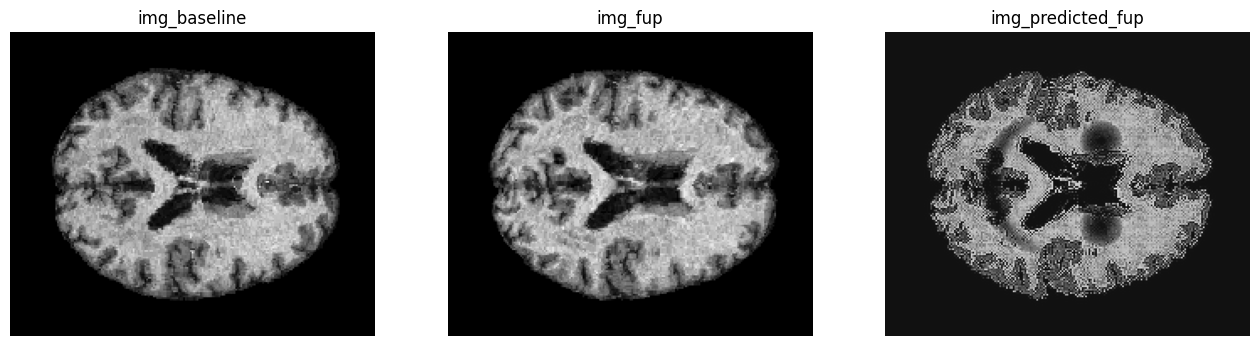

In [9]:
p = pil.IMG_NUMBERS_TEST[0]
img_baseline, _ = pil.load_nsk_volume(p, 1, pil.FOLDER_REGISTERED)
img_fup, _ = pil.load_nsk_volume(p, 2, pil.FOLDER_REGISTERED)
img_predicted_fup, _ = pil.load_predicted_volume(p, 2, pil.FOLDER_REGISTERED)

print(img_predicted_fup.shape)
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
fc.imgshow_matplotlib("img_baseline", img_baseline[...,90], subplot=axs[0])
fc.imgshow_matplotlib("img_fup", img_fup[...,90], subplot=axs[1])
fc.imgshow_matplotlib("img_predicted_fup", img_predicted_fup[...,90], subplot=axs[2])

